# The Plan

## Read in CSV Data


## Formalize State 


## Make Markov Chain


## Histogram of States


## Visualize Markov Chain


## Sample from Chain and Evaluate Stock Price Predictions
    ## Random Walk
    ## Greedy Choice


## Sample from Chain Evaluate Sentiment Predictions
    ## Random Walk
    ## Greedy Choice

In [155]:
import pandas as pd

df = pd.read_csv('AAPL-histnews-merged.csv')
df

,created_at,Sentiment_New,Price
0,2022-12-30,neutral,129.93
1,2022-12-30,neutral,129.93
2,2022-12-30,positive,129.93
3,2022-12-30,positive,129.93
4,2022-12-30,positive,129.93
...,...,...,...
20416,2015-01-05,neutral,26.56
20417,2015-01-02,neutral,27.33
20418,2015-01-02,neutral,27.33
20419,2015-01-02,negative,27.33


                  (neutral, down)  (negative, down)  (neutral, up)  (negative, up)  (positive, up)  (positive, down)
(neutral, down)              0.22              0.14           0.26            0.09            0.17              0.13
(negative, down)             0.16              0.17           0.21            0.15            0.18              0.13
(neutral, up)                0.24              0.10           0.24            0.10            0.18              0.15
(negative, up)               0.19              0.16           0.19            0.08            0.22              0.16
(positive, up)               0.19              0.09           0.22            0.07            0.23              0.19
(positive, down)             0.18              0.13           0.22            0.14            0.22              0.12


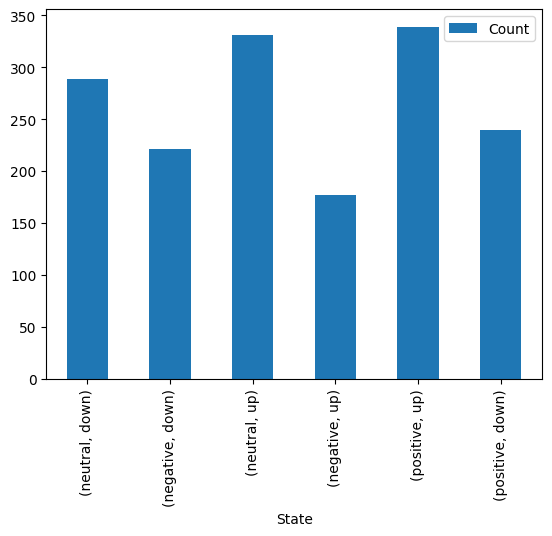

In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate the last price and overall sentiment for each day
df_daily = df.groupby('created_at').agg({'Sentiment_New': lambda x: x.mode()[0], 'Price': 'last'})

# Calculate stock movement based on daily prices
df_daily['Stock_Movement'] = df_daily['Price'].diff()
df_daily['Stock_Movement'] = df_daily['Stock_Movement'].apply(lambda x: 'up' if x >= 0 else 'down')

# Create states
df_daily['State'] = list(zip(df_daily['Sentiment_New'], df_daily['Stock_Movement']))

# Split into training and test set
df_train, df_test = train_test_split(df_daily, test_size=0.2, shuffle=False)

# Calculate transition probabilities
states = df_train['State'].unique()
n_states = len(states)
transition_matrix = np.zeros((n_states, n_states))

for (i, state1), (j, state2) in zip(enumerate(df_daily['State']), enumerate(df_daily['State'][1:])):
    for a, state3 in enumerate(states):
        for b, state4 in enumerate(states):
            if state1 == state3 and state2 == state4:
                transition_matrix[a, b] += 1


# Normalize the transition matrix
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Create a DataFrame for easier viewing
df_transition = pd.DataFrame(transition_matrix, index=states, columns=states)

print(df_transition)

# Create histogram for state frequencies in the training set
state_counts = Counter(df_train['State'])
df_state_counts = pd.DataFrame.from_dict(state_counts, orient='index').reset_index()
df_state_counts = df_state_counts.rename(columns={'index':'State', 0:'Count'})
df_state_counts.plot(kind='bar', x='State', y='Count')
plt.show()

# Predict the next state for each state in the test set
test_states = df_test['State'].values

In [161]:
states = list(states)
print(states)

[('neutral', 'down'), ('negative', 'down'), ('neutral', 'up'), ('negative', 'up'), ('positive', 'up'), ('positive', 'down')]


In [168]:
# Evaluation           
test_states_predicted = [states[np.argmax(transition_matrix[states.index(state)])] for state in test_states[:-1]]
test_states_predicted = list(map(tuple, test_states_predicted))

overall_acc = 0
for i in range(len(test_states[1:])):
    if test_states_predicted[i] == test_states[1:][i]:
        overall_acc += 1
overall_acc /= len(test_states[1:])
sentiment_acc = np.mean([s1[0] == s2[0] for s1, s2 in zip(test_states[1:], test_states_predicted)])
movement_acc = np.mean([s1[1] == s2[1] for s1, s2 in zip(test_states[1:], test_states_predicted)])

print(f"Overall accuracy: {overall_acc}")
print(f"Sentiment accuracy: {sentiment_acc}")
print(f"Stock movement accuracy: {movement_acc}")

Overall accuracy: 0.3057644110275689
Sentiment accuracy: 0.5714285714285714
Stock movement accuracy: 0.5238095238095238


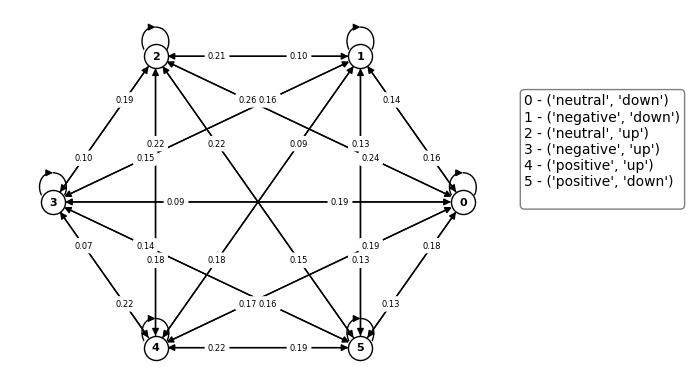

In [169]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.DiGraph()

# G.add_nodes_from(states)
G.add_nodes_from([i for i in range(len(states))])


# add edges to the graph with the transition probabilities as edge labels
for i, row in enumerate(transition_matrix):
    for j, prob in enumerate(row):
#         G.add_edge(states[i],states[j], weight=prob)
        G.add_edge(i, j, weight=prob)

        

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black')
nx.draw_networkx_edges(G, pos)
edge_labels = {(u, v): '{:.2f}'.format(d['weight']) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=6, rotate=False)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
plt.axis('off')

plt.savefig('markov_chain.png', dpi=300)


text_str = ""
for i in range(len(states)):
    text_str += f"{i} - {str(states[i])}\n"

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(1.3, 0, text_str, bbox=props)
plt.show()

plt.show()

In [170]:
table_df = pd.DataFrame(transition_matrix, index=states, columns=states)

# format the DataFrame for display
# pd.set_option('precision', 2)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
print(table_df)

                  (neutral, down)  (negative, down)  (neutral, up)  (negative, up)  (positive, up)  (positive, down)
(neutral, down)              0.22              0.14           0.26            0.09            0.17              0.13
(negative, down)             0.16              0.17           0.21            0.15            0.18              0.13
(neutral, up)                0.24              0.10           0.24            0.10            0.18              0.15
(negative, up)               0.19              0.16           0.19            0.08            0.22              0.16
(positive, up)               0.19              0.09           0.22            0.07            0.23              0.19
(positive, down)             0.18              0.13           0.22            0.14            0.22              0.12
